# Kernel choice

We are trying to predict mid price indicator using queue imbalance feature using SVM for LOB.

Goal of this notebook is to find method for choosing SVM kernel for each stock. We will look at correlations between introduced additional metrics based on ask and bid queues. We will also look if these metrics have some correlation with the score result (we use roc area score for comparing results).

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC

from sklearn import preprocessing

import warnings

from lob_data_utils import lob, db_result

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

## Data preparation

We load:
* `df_res_cv` - dataset with results for validation sets extracted from full-data length stocks.
* `dfs`, `dfs_test`, `dfs_cv` - dictionaries of dataframes with data with stock-ids as keys and dataframes for train data, test data and validation data.

#### Description of DataFrames in `dfs`, `dfs_test`, `dfs_cv`

The data is indexed with time $t$.

* `bid` - bid queue
* `ask` - ask queue
* `bid_price` - bid price $b(t)$
* `ask_price` - ask price $a(t)$
* `mid_price` - mid price $m(t)$
* `sum_sell_ask` - total size of active sell orders for ask price  $ n^{a}(a(t), t) $
* `sum_buy_bid` - total size of active buy orders for bid price  $ n^{b}(b(t), t) $
* `mid_price_indicator` - the indicator if the mid price will rise in the **next** time tick
* `queue_imbalance` - $I(t)$

In [2]:
df_res_cv = pd.DataFrame(db_result.get_svm_results_for_data_length(0, 'cv'))

dfs = {}
dfs_test = {}
dfs_cv = {}

stocks = df_res_cv['stock'].unique()

for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(s, cv=True, length=None)
    dfs[s] = d
    dfs_test[s] = d_test

#### Description of `df_res_cv`

This data set contains calculation results for validation set and parameters.

* `c` - C parameter for svm kernel - it's used by **linear**, **rbf** and **sigmoid** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by **rbf** and **sigmoid** kernels, for linear it's set to $-1$.
* `coef0` - coef0 parameter for **sigmoid** kernel only - for other kernels it's set to -1.
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from full-dataset.

In [3]:
df_res_cv.drop('algorithm_id', axis=1, inplace=True)
df_res_cv.drop('svm_id', axis=1, inplace=True)
df_res_cv.drop('id', axis=1, inplace=True)
df_res_cv.drop('data_length', axis=1, inplace=True) # TODO: do not drop that
df_res_cv.drop('name', axis=1, inplace=True)
df_res_cv.drop('data_type', axis=1, inplace=True)
df_res_cv.head()

,c,coef0,gamma,kernel,roc_auc_score,stock
0,100.0000,0.0,-1.0,linear,0.563885,9094
1,1000.0000,0.0,-1.0,linear,0.563885,9094
2,0.0001,0.0,-1.0,linear,0.500000,9270
3,0.0010,0.0,-1.0,linear,0.512404,9270
4,1.0000,0.0,-1.0,linear,0.550741,9270


#### Description of `df_bests`

In this data set we aggregate calculations with the best **roc area score** by stock. It has the same fields as `df_res_cv`.

* `c` - C parameter for svm kernel - it's used by **linear**, **rbf** and **sigmoid** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by **rbf** and **sigmoid** kernels, for linear it's set to $-1$.
* `coef0` - coef0 parameter for **sigmoid** kernel only - for other kernels it's set to -1.
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from full-dataset.

In [4]:
bests = []
df_best_agg = df_res_cv.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests = df_res_cv.loc[df_best_agg]
df_bests.index = df_bests['stock']
df_bests.head()

,c,coef0,gamma,kernel,roc_auc_score,stock
stock,,,,,,
10166,0.001,10.0,1000.0,sigmoid,0.564622,10166
10470,0.001,1.0,100.0,sigmoid,0.598329,10470
10484,0.001,10.0,100.0,sigmoid,0.555384,10484
10508,0.001,10.0,100.0,sigmoid,0.568278,10508
10795,1000.000,0.0,10.0,rbf,0.610659,10795


## Introducing additional metrics

We are looking for some metric which will help us determine which SVM kernel will work the best for each stock.

We introduce metrics:

* sum_sell_ask_mean - mean of sum_sell_ask (mean of total size of active sell orders for ask price  $ n^{a}(a(t), t) $)
* sum_buy_bid_mean - mean of sum_buy_bid (mean of total size of active buy orders for bid price  $ n^{b}(b(t), t) $)
* max_trade_price - max trade price
* min_trade_price - min trade price
* bid_ask_spread - mean difference between ask and bid price
* max_len_ask - max ask queue length
* max_len_bid - max bid queue length
* mean_len_ask - mean ask queue length
* mean_len_bid - mean bid queue length
* mean_bid_ask_len - mean ask and bid queues lengths

In [5]:
df_summary = lob.prepare_summary(stocks, dfs)
data_length = []

for s in stocks:
    data_length.append(len(dfs[s]))

df_summary['data_length'] = data_length

In [6]:
df_bests.sort_index(inplace=True)
df_summary.sort_index(inplace=True)
df_summary = df_summary.join(df_bests)
kernel_names = {"linear": 0, 'sigmoid': 2, "rbf": 1}
df_summary['kernel_class'] = [kernel_names.get(n) for n in df_summary['kernel'].values]

df_summary.head()

,sum_sell_ask_mean,sum_buy_bid_mean,max_trade_price,min_trade_price,bid_ask_spread,max_len_ask,max_len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len,data_length,c,coef0,gamma,kernel,roc_auc_score,stock,kernel_class
10166,781.091539,837.844636,3454.5,2965.0,1.218087,1222,1446,901.177724,960.957695,841.397754,9526,0.001,10.0,1000.0,sigmoid,0.564622,10166,2
10470,951.811200,1089.178571,2510.0,2208.0,1.712552,737,717,516.341886,548.962725,483.721047,5768,0.001,1.0,100.0,sigmoid,0.598329,10470,2
10484,2717.441484,2814.923796,358.4,316.2,0.286286,740,682,466.049556,476.536232,455.562880,6417,0.001,10.0,100.0,sigmoid,0.555384,10484,2
10508,3688.154709,3825.060165,382.4,341.3,0.245577,749,834,550.529008,595.837173,505.220843,8377,0.001,10.0,100.0,sigmoid,0.568278,10508,2
10795,2345.858763,2034.958852,1644.0,1440.0,1.571397,597,598,383.979871,441.729315,326.230427,4496,1000.000,0.0,10.0,rbf,0.610659,10795,1


## Correlations between metrics

Below we can see correlation plot for introduced metrics. 

Obvious strong-correlations are: 

* `sum_sell_ask_mean` and `sum_buy_bid_mean`
* `max_trade_price` and `min_trade_price`
* `max_len_ask` and `max_len_bid`

Medium correlations, which don't seem interesting are:

* `sum_sell_ask_mean` with `max_trade_price`, `min_trade_price`
* `sum_sell_bid_mean` with `max_trade_price`, `min_trade_price`

Interesting correlations:

* `data_length` and `roc_auc_score` has correlation about -0.8 - this shouldn't happen!
* `max_len_ask` and `max_len_bid` both have correlation about -0.6 with `roc_auc_score`
* no correlation between `kernel_class` and any of these metrics

In [7]:
kernel_names = {"linear": 0, 'sigmoid': 2, "rbf": 1}
df_summary['kernel_class'] = [kernel_names.get(n) for n in df_summary['kernel'].values]

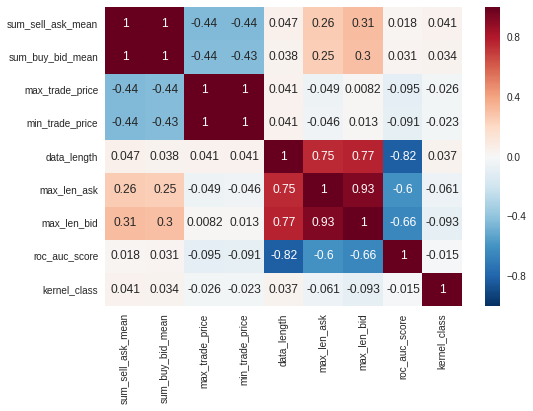

In [8]:
features = ['sum_sell_ask_mean', 'sum_buy_bid_mean', 'max_trade_price', 'min_trade_price',
           'data_length', 'max_len_ask', 'max_len_bid', 'roc_auc_score', 'kernel_class']
sns.heatmap(df_summary[features].corr(), annot=True)

Unfortunatelly we don't see any correlation between any of these metric and `kernel_class`.

Interesting correlations:

* `mean_ask_len` and `mean_bid_ask` and `mean_bid_ask_len` have correlation about -0.6 with `roc_auc_score`
* no correlation between `kernel_class` and any of these metrics

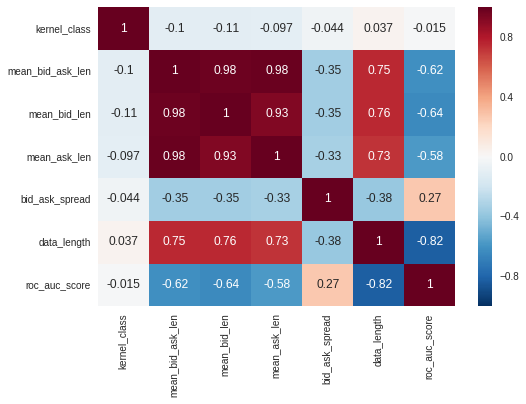

In [9]:
features = ['kernel_class', 'mean_bid_ask_len', 'mean_bid_len', 'mean_ask_len',
            'bid_ask_spread', 'data_length', 'roc_auc_score']
sns.heatmap(df_summary[features].corr(), annot=True)

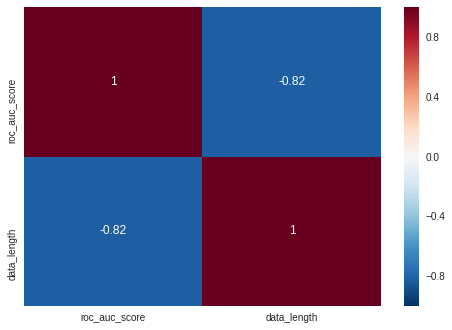

In [10]:
sns.heatmap(df_summary[['roc_auc_score', 'data_length']].corr(), annot=True)

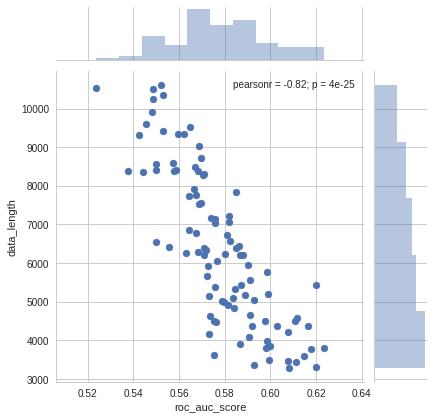

In [11]:
sns.jointplot("roc_auc_score", "data_length", data=df_summary)

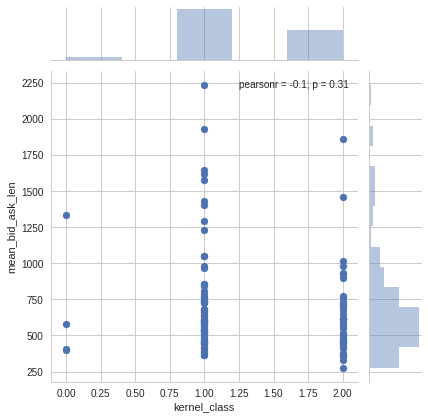

In [12]:
sns.jointplot("kernel_class", "mean_bid_ask_len", data=df_summary)

## Best kernel distrubution


We use violin plots to plot the kernel KDE distributions against `mean_bid_ask_len`. We choosen `mean_bid_ask_len` metric, because it's symmetric and comparable accross different stocks.
* white dot represents the median
* thick gray bar in the center represents the interquartile range
* thin gray line represents the 95% confidence interval

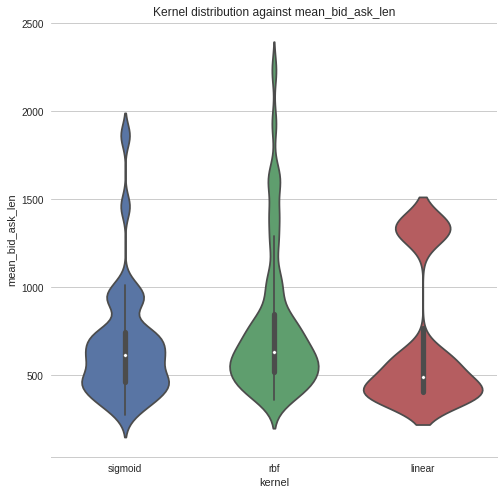

In [13]:
f, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(x='kernel', 
           y='mean_bid_ask_len', data=df_summary, cut=2, bw=0.2)
sns.despine(left=True)
plt.title('Kernel distribution against mean_bid_ask_len')

It seems it might be biased, because our data doesn't have normal distribution for `mean_bid_ask_len` metric.

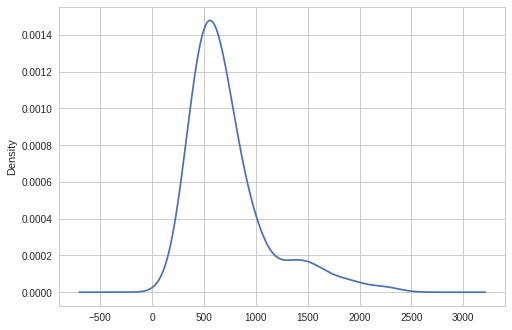

In [14]:
df_summary['mean_bid_ask_len'].plot('kde')

## Learning curves

We plot learning curves using 3-fold cross validation method (it uses consecutive folds) for longest and shortest data grouped by kernels.

In [15]:
df_best_agg = df_res_cv.groupby(['stock', 'kernel'], as_index=False)['roc_auc_score'].idxmax()
df_bests_by_kernels = df_res_cv.loc[df_best_agg]
data_len = []
for i, row in df_bests_by_kernels.iterrows():
    data_len.append(len(dfs[row['stock']]))
df_bests_by_kernels['data_length'] = data_len
df_bests_by_kernels.head()

,c,coef0,gamma,kernel,roc_auc_score,stock,data_length
30169,0.005,0.0,-1.0000,linear,0.557893,10166,9526
30194,500.000,0.0,0.0005,rbf,0.558478,10166,9526
6213,0.001,10.0,1000.0000,sigmoid,0.564622,10166,9526
320,1.000,0.0,-1.0000,linear,0.594828,10470,5768
2510,1.000,0.0,1.0000,rbf,0.596540,10470,5768


In [16]:
def plot_learning_curve_for_idx(df_best_by_kernels, idx):
    for i in idx.index:
        row = df_bests_by_kernels.loc[i]
        s = row['stock']
        gamma = row['gamma']
        if row['gamma'] == -1:
            gamma = 'auto'
        clf = SVC(kernel=row['kernel'], C=row['c'], gamma=gamma, coef0=row['coef0'])
        lob.plot_learning_curve(clf, X=dfs[s]['queue_imbalance'].reshape(-1, 1), 
                            y=dfs[s]['mid_price_indicator'],
                               title=row['stock'] + ' ' + row['kernel'])
        plt.figure()

#### Linear kernel for longest data

It looks that for linear kernel we suffer from underfitting for 9064 and 9062 (the training line and cross-validation line are getting closer, but the score is decreasing too).

For 11244 it looks like linear kernel is a good fit.

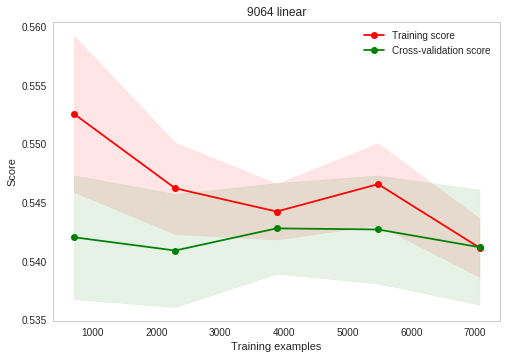

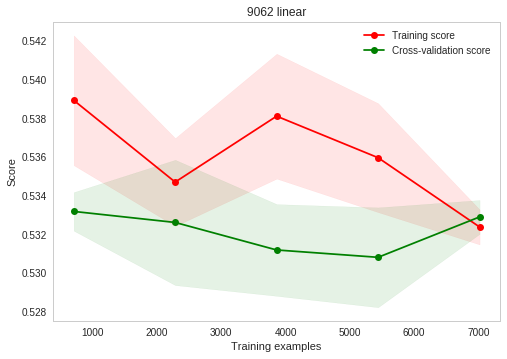

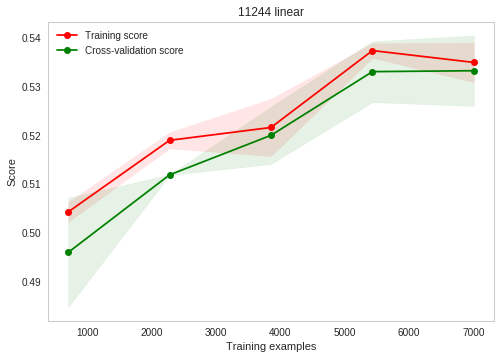

In [17]:
longest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'linear']['data_length'].nlargest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, longest_idx)

#### RBF kernel for longest data

For rbf kernel for 9064, 9062 and 11244 it looks like we are still underfitting - it doesn't seem that we are improving much with additional data.

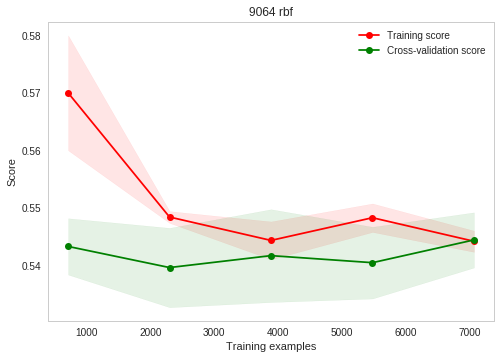

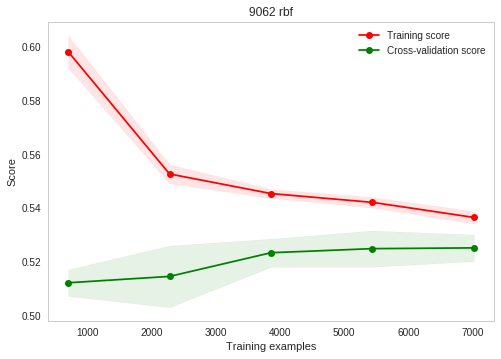

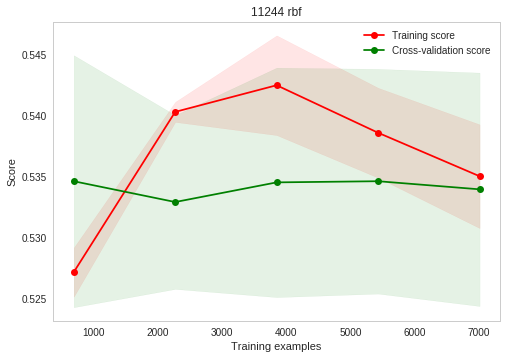

In [18]:
longest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'rbf']['data_length'].nlargest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, longest_idx)

#### Simogid kernel for longest data

Sigmoid kernel looks like a good fit, it might be that more data would help.

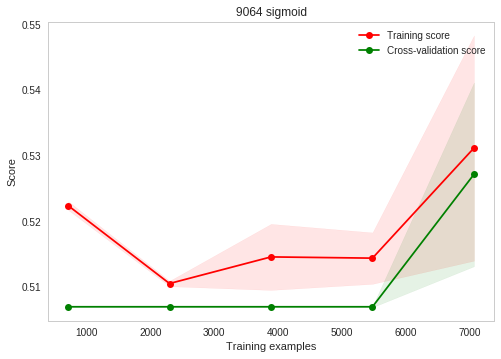

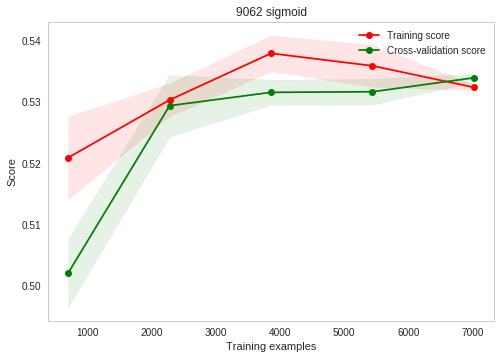

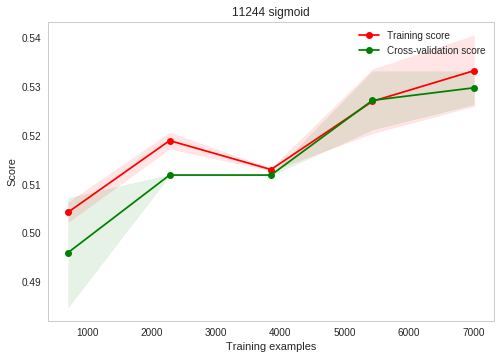

In [19]:
longest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'sigmoid']['data_length'].nlargest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, longest_idx)

#### Linear kernel for shortest data

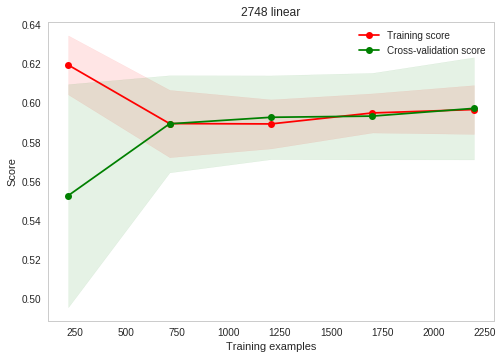

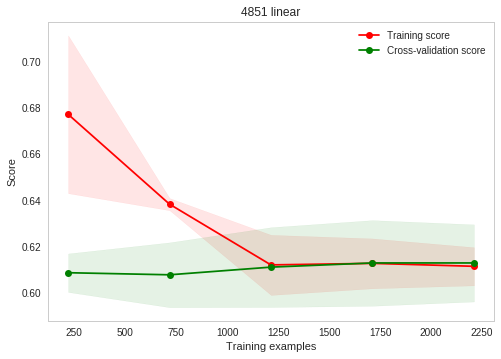

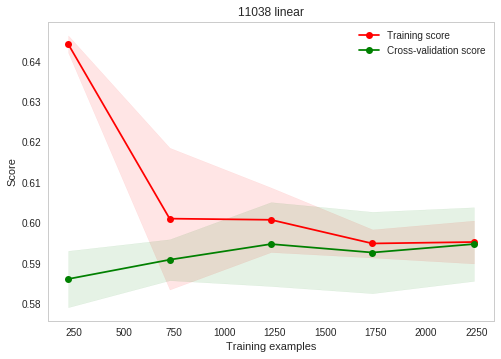

In [20]:
smallest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'linear']['data_length'].nsmallest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, smallest_idx)

#### RBF kernel for shortest data

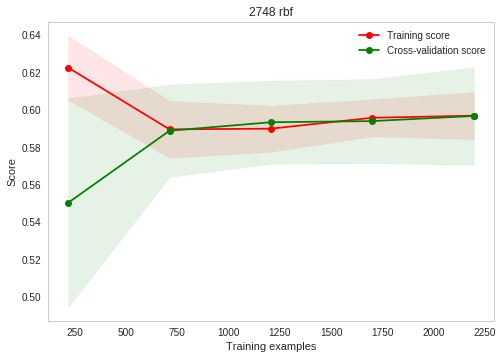

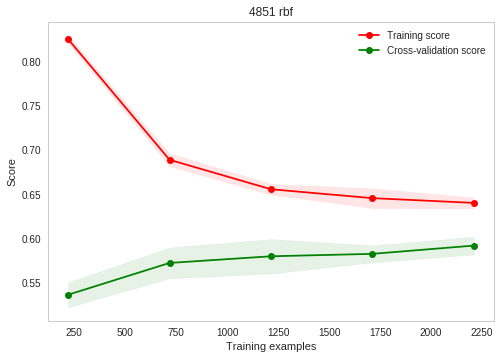

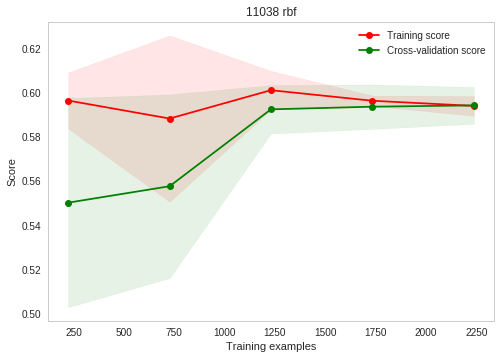

In [21]:
smallest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'rbf']['data_length'].nsmallest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, smallest_idx)

#### Simoid kernel for shortest data

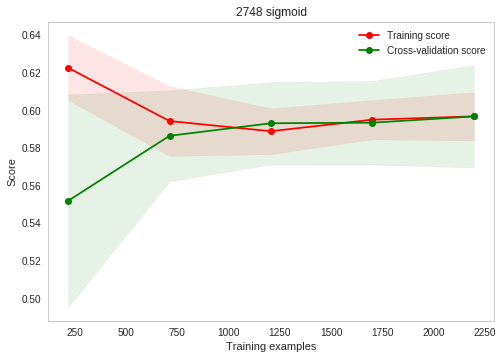

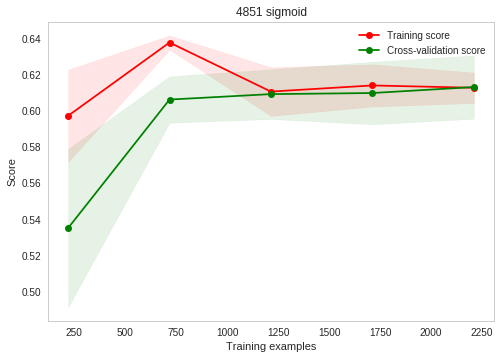

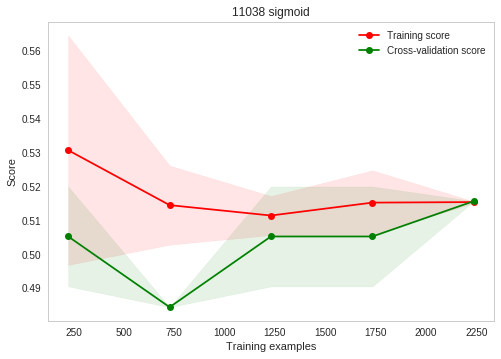

In [22]:
smallest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'sigmoid']['data_length'].nsmallest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, smallest_idx)

## Conclusions

We need to use data with the same amount of data points for comparing results.

We didn't find a metric which has any correlation with kernel, but `mean_bid_ask_len` metric seems to be a good choice to at least distinguish between stocks which give good roc scores.

As a next steps we will perform similar analysis for each data length:
* 5050 (98 stocks) in [kernel_choice-5050.ipynb](kernel_choice-5050.ipynb)
* 10000 (50 stocks) in [kernel_choice-10000.ipynb](kernel_choice-10000.ipynb)
* 15000 (13 stocks) in [kernel_choice-15000.ipynb](kernel_choice-15000.ipynb)
to check the hypothesis.

We will show parameter tuning results for each data length (also per kernel):
* 5050 in [results/results_validation_best_5050.ipynb](results/results_validation_best_5050.ipynb)
* 10000 in [results/results_validation_best_10000.ipynb](results/results_validation_best_10000.ipynb)
* 15000 in [results/results_validation_best_15000.ipynb](results/results_validation_best_15000.ipynb)

We will show testing set results for each data length (also per kernel):
* 5050 in [results/compare_test_5050.ipynb](results/compare_test_5050.ipynb)
* 10000 in [results/compare_test_10000.ipynb](results/compare_test_10000.ipynb)
* 15000 in [results/compare_test_15000.ipynb](results/compare_test_15000.ipynb)